# Kaggle RSNA Intracranial Hemorrhage Detection

Ce notebook utilise les données de la compétition [Kaggle RSNA Intracranial Hemorrhage Detection](https://www.kaggle.com/competitions/rsna-intracranial-hemorrhage-detection/overview) pour entraîner un modèle de diffusion stable à générer des images médicales.

## Sommaire

- [0. Importation des bibliothèques](#0-Importation-des-bibliothèques)
- [1. Chargement et prétraitement des données](#1-Chargement-et-prétraitement-des-données)
- [2. Définition du modèle de diffusion](#2-Définition-du-modèle-de-diffusion)
- [3. Entraînement du modèle](#3-Entraînement-du-modèle)
- [4. Génération d'images](#4-Génération-d'images)
- [5. Conclusion](#5-Conclusion)

## 0. Importation des bibliothèques

In [14]:
import pandas as pd
from typing import List
import subprocess
from pathlib import Path
import kaggle

## 1. Chargement et prétraitement des données

Nous allons d'abord charger la liste des identifiants et labels du jeu de données d'entraînement. L'API Kaggle est une option, ou sinon vous pouvez télécharger le fichier CSV manuellement depuis la [page de la compétition](https://www.kaggle.com/competitions/rsna-intracranial-hemorrhage-detection/data) et le placer dans le répertoire `../data/rsna-intracranial-hemorrhage-detection`.  

In [15]:
COMPETITION_NAME = "rsna-intracranial-hemorrhage-detection"
DATA_DIRECTORY = "../data/" + COMPETITION_NAME

In [16]:
train_dataset_listing = pd.read_csv(f"{DATA_DIRECTORY}/stage_2_train.csv")

In [17]:
train_dataset_listing.head()

,ID,Label
0,ID_12cadc6af_epidural,0
1,ID_12cadc6af_intraparenchymal,0
2,ID_12cadc6af_intraventricular,0
3,ID_12cadc6af_subarachnoid,0
4,ID_12cadc6af_subdural,0


In [18]:
train_dataset_listing['Label'].unique()

array([0, 1])

On voit donc que les "ID" sont de la forme "ID_ImageID_HemorrhageType", et que la colonne "Label" ne peut prendre que les valeurs 0 ou 1. Nous allons donc créer une nouvelle colonne "ImageID" qui ne contiendra que la partie "ImageID" de l'ID, et une colonne "HemorrhageType" qui contiendra la partie "HemorrhageType".

In [19]:
train_dataset_listing['HemorrhageType'] = train_dataset_listing['ID'].str.split("_", n = 3, expand = True)[2]
train_dataset_listing['ImageID'] = train_dataset_listing['ID'].str.split("_", n = 3, expand = True)[1]


In [20]:
train_dataset_listing.head()

,ID,Label,HemorrhageType,ImageID
0,ID_12cadc6af_epidural,0,epidural,12cadc6af
1,ID_12cadc6af_intraparenchymal,0,intraparenchymal,12cadc6af
2,ID_12cadc6af_intraventricular,0,intraventricular,12cadc6af
3,ID_12cadc6af_subarachnoid,0,subarachnoid,12cadc6af
4,ID_12cadc6af_subdural,0,subdural,12cadc6af


Partant de là, on peut maintenant faire la liste des ImageID uniques :

In [21]:
unique_image_ids = train_dataset_listing['ImageID'].unique()
print(f"Number of unique ImageIDs: {len(unique_image_ids)}")

Number of unique ImageIDs: 752803


Nous allons pouvoir maintenant charger les images DICOM correspondantes à ces ImageID. Pour cela, nous allons créer une fonction qui, pour une liste d'ImageIDs donnée, charge l'image DICOM correspondante, dans un dossier spécifié.

In [22]:
def download_images(image_ids: List[str],
                    destination_directory: str = DATA_DIRECTORY):
    """
    Download DICOM files from Kaggle CLI.

    Parameters
    ----------
    image_ids : List[str]
        List of DICOM IDs to download (without extension)
    destination_directory : str
        Path to the directory where to save the downloaded files
    """
    Path(destination_directory).mkdir(parents=True, exist_ok=True)

    for iid in image_ids:
        remote_path = f"rsna-intracranial-hemorrhage-detection/stage_2_train/ID_{iid}.dcm"
        subprocess.run(
            [
                "kaggle", "competitions", "download",
                "-c", COMPETITION_NAME,
                "-f", remote_path,
                "-p", destination_directory
            ],
            check=True
        )

Testons cette fonction en téléchargeant les images correspondant aux 5 premiers ImageIDs uniques :

In [24]:
first_5_image_ids = unique_image_ids[:5]
download_images(first_5_image_ids)

100%|██████████| 513k/513k [00:00<00:00, 377MB/s]


100%|██████████| 513k/513k [00:00<00:00, 1.48GB/s]


100%|██████████| 513k/513k [00:00<00:00, 465MB/s]


100%|██████████| 513k/513k [00:00<00:00, 1.26GB/s]


100%|██████████| 513k/513k [00:00<00:00, 846MB/s]


Maintenant que nous avons les images, nous allons les visualiser pour vérifier que tout est correct :

In [25]:
def list_downloaded_images(destination_directory: str = DATA_DIRECTORY) -> List[Path]:
    """
    List all downloaded DICOM files in the destination directory.

    Parameters
    ----------
    destination_directory : str
        Path to the directory where the files are saved

    Returns
    -------
    List[Path]
        List of paths to the downloaded DICOM files
    """
    return list(Path(destination_directory).glob("ID_*.dcm"))

In [26]:
list_downloaded_images()

[PosixPath('../data/rsna-intracranial-hemorrhage-detection/ID_aec8e68b3.dcm'),
 PosixPath('../data/rsna-intracranial-hemorrhage-detection/ID_6c5d82413.dcm'),
 PosixPath('../data/rsna-intracranial-hemorrhage-detection/ID_12cadc6af.dcm'),
 PosixPath('../data/rsna-intracranial-hemorrhage-detection/ID_4d9209c7c.dcm'),
 PosixPath('../data/rsna-intracranial-hemorrhage-detection/ID_38fd7baa0.dcm')]

In [28]:
import pydicom
import matplotlib.pyplot as plt

def visualize_image(image_id: str,
                    destination_directory: str = DATA_DIRECTORY):
    """
    Visualize a DICOM image.

    Parameters
    ----------
    image_id : str
        ID of the DICOM file to visualize (without extension)
    destination_directory : str
        Path to the directory where the files are saved
    """
    dicom_path = Path(destination_directory) / f"ID_{image_id}.dcm"
    dicom_data = pydicom.dcmread(dicom_path)
    plt.imshow(dicom_data.pixel_array, cmap=plt.cm.gray)
    plt.title(f"Image ID: {image_id}")
    plt.axis('off')
    plt.show()

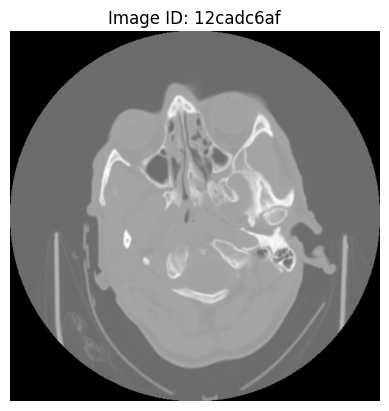

In [29]:
visualize_image(first_5_image_ids[0])